<a href="https://colab.research.google.com/github/SmartPracticeschool/SBSPS-Challenge-1322-Predicting-the-energy-output-of-wind-turbine-based-on-weather-condition/blob/master/Wind_power_generation_forecast_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import torch

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset 3.csv to dataset 3.csv


In [3]:

dataset = pd.read_csv("dataset 3.csv", encoding= 'unicode_escape')
TRAIN_SPLIT = 52561

In [4]:
print (dataset)

               Date/Time  ...  Wind Speed (m/s)
0           1 1 2018 0:0  ...            16.418
1          1 1 2018 0:10  ...            16.653
2          1 1 2018 0:20  ...            16.919
3          1 1 2018 0:30  ...            16.989
4          1 1 2018 0:40  ...            17.096
...                  ...  ...               ...
105115  31 12 2019 23:15  ...            17.670
105116  31 12 2019 23:25  ...            16.965
105117  31 12 2019 23:35  ...            16.214
105118  31 12 2019 23:45  ...            16.116
105119  31 12 2019 23:55  ...            16.345

[105120 rows x 4 columns]


In [5]:
df = dataset
features_considered = ['Wind Speed (m/s)', 'LV ActivePower (kW)', 'Wind Direction (°)']
features = df[features_considered]
features.index = df['Date/Time']
features.head()

,Wind Speed (m/s),LV ActivePower (kW),Wind Direction (°)
Date/Time,,,
1 1 2018 0:0,16.418,16000,336.296
1 1 2018 0:10,16.653,16000,337.510
1 1 2018 0:20,16.919,16000,337.927
1 1 2018 0:30,16.989,16000,338.174
1 1 2018 0:40,17.096,16000,338.433


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1522fb0940>,
      dtype=object)

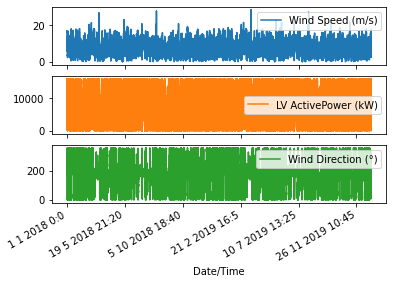

In [6]:
features.plot(subplots=True)

In [7]:
dataset = features.values
print(dataset)

data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

[[   16.418 16000.      336.296]
 [   16.653 16000.      337.51 ]
 [   16.919 16000.      337.927]
 ...
 [   16.214 16000.      333.703]
 [   16.116 16000.      334.406]
 [   16.345 16000.      335.845]]


In [8]:
dataset = (dataset-data_mean)/data_std

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [10]:
past_history = 720
future_target = 72
STEP = 6
BUFFER_SIZE = 10000
BATCH_SIZE = 256

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP) 

In [11]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target power to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target power to predict : (72,)


In [12]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [13]:
def create_time_steps(length):
  return list(range(-length, 0))

In [14]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

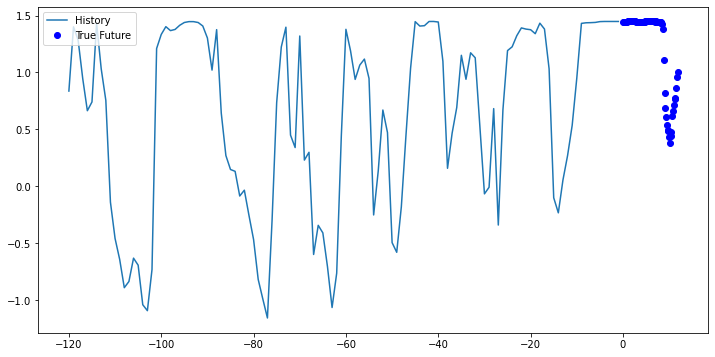

In [15]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [16]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer='adam', loss='mae')

In [17]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [18]:
EVALUATION_INTERVAL = 200
EPOCHS = 50

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/50
200/200 [==============================] - 59s 294ms/step - loss: 0.7857 - val_loss: 0.6989
Epoch 2/50
200/200 [==============================] - 58s 292ms/step - loss: 0.6076 - val_loss: 0.6599
Epoch 3/50
200/200 [==============================] - 58s 291ms/step - loss: 0.5631 - val_loss: 0.6480
Epoch 4/50
200/200 [==============================] - 58s 289ms/step - loss: 0.5452 - val_loss: 0.6155
Epoch 5/50
200/200 [==============================] - 59s 293ms/step - loss: 0.5237 - val_loss: 0.5996
Epoch 6/50
200/200 [==============================] - 59s 293ms/step - loss: 0.5035 - val_loss: 0.5751
Epoch 7/50
200/200 [==============================] - 58s 291ms/step - loss: 0.4788 - val_loss: 0.5589
Epoch 8/50
200/200 [==============================] - 59s 294ms/step - loss: 0.4550 - val_loss: 0.5363
Epoch 9/50
200/200 [==============================] - 59s 293ms/step - loss: 0.4343 - val_loss: 0.4962
Epoch 10/50
200/200 [==============================] - 58s 291ms/step - l

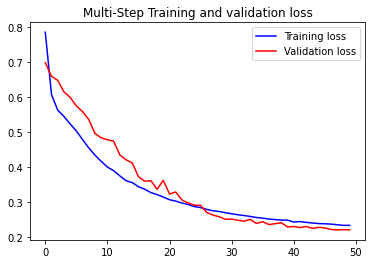

In [19]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

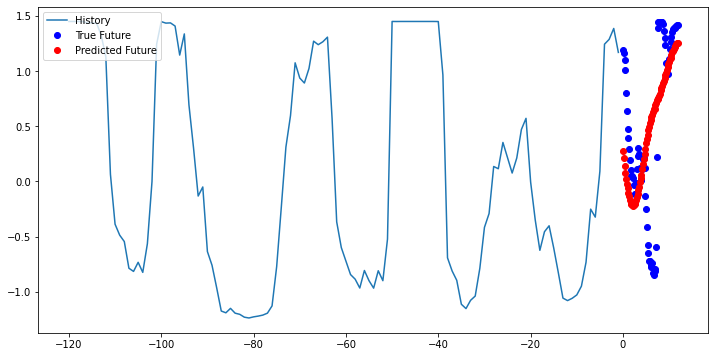

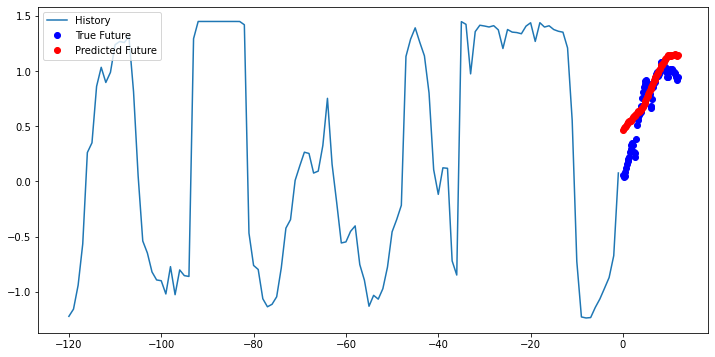

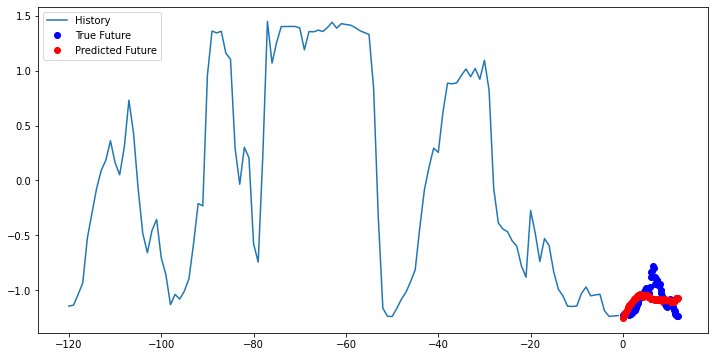

In [20]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [21]:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [ ]:
multi_step_model.save('model.h5')
model_file = drive.CreateFile({'title' : 'model.h5'})                       
model_file.SetContentFile('model.h5')                       
model_file.Upload()

In [ ]:
# download to google drive                       
drive.CreateFile({'id': model_file.get('id')})